## Fouesnau Catalog Plots

* [Catalog Plots](#section1)
* [Join Fouesneau, Gaia RV and 2MASS data](#section2)
* [Checks between Fouesnau and Crossmatched 2MASS](#section3)
* [2D Histograms](#section4)
* [Sample Cuts](#section5)
* [Gaia photometry](##section6)
* [Fitting Across ROI](#section7)
---

In [2]:
from astroquery.gaia import Gaia
import warnings

# Comment this out if you want to see warnings
warnings.filterwarnings('ignore')
import astropy
import requests
import pyvo as vo
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import glob
import os
import requests
import sys
sys.path.append("../gaia_tools/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data
import vaex

In [3]:
plt.rc('text', usetex=False)

def scatter_hist(x, y, ax, ax_histx, ax_histy, xlim_min, xlim_max, ylim_min, ylim_max):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    range = [[xlim_min, xlim_max], [ylim_min, ylim_max]]
    h = ax.hist2d(x, y, range=range, bins=250, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
    ax.scatter(x, y, alpha=0.05, s=1, color='k', zorder=0)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))

    axins = inset_axes(ax,
                    width="100%",  
                    height="3%",
                    loc='lower center',
                    borderpad=-7)
    cb = fig.colorbar(h[3], cax=axins, ax=ax, pad=0.02, format=fmt, orientation='horizontal')

   

    # the scatter plot:
    #ax.scatter(x, y, alpha=0.1, s=0.5)
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)

    ax.set_xlabel(r'$J - K_s$ [mag]', fontdict={'fontsize' : 14})
    ax.set_ylabel(r'$H$ [mag]',  fontdict={'fontsize' : 14})

    ax.set_yticks(np.arange(ylim_min, ylim_max, 2))

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 40
    ax_histx.hist(x, bins=3*bins, histtype='step', linewidth = 2, density=True)
    ax_histy.hist(y, bins=bins, histtype='step', linewidth = 2, orientation='horizontal', density=True)

    ax_histx.set_yticks([])
    ax_histy.set_xticks([])

    ax.vlines([0.5, 1.1], ylim_min, ylim_max, linestyles='dashed', alpha=0.5, colors='orange')
    ax.hlines([-1.5, -1.5 + 0.04, -1.5 - 0.04], xlim_min, xlim_max, linestyles='dashed', alpha=0.25,  colors='r', label=r'H=-1.5')
    ax.hlines([-1.5 + 0.04, -1.5 - 0.04], xlim_min, xlim_max, linestyles='dotted', alpha=0.25,  colors='r')

In [5]:
# Only need these columns 
columns = ['source_id', 'J_p50', 'Ks_p50', 'H_p50', 'J_sigma', 'Ks_sigma', 'H_sigma', 'parallax', 'parallax_sigma']

df=vaex.open('/scratch/sven/gaia_downloads/catalog-20210311-goodphot_lite_nodup.vaex.hdf5')
df['source_id'] = df.source_id.astype('int64')
df.shape

df = df[columns]
print(df.shape)

(123076271, 196)

## Catalog Plots <a class="anchor" id="section1"></a>

### Uncorrected vs extinction corrected 2MASS

In [ ]:
from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = df[filters_fouesnau[i]].values
    y_values = df[filters_fouesnau[i]+'_p50'].values

    range = [[-10, 20], [-10, 20]]

    h = axs[i].hist2d(x_values, y_values, range=range, bins=250, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
    axs[i].scatter(x_values, y_values, alpha=0.05, s=1, color='k', zorder=0)

    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cb = fig.colorbar(h[3], ax=axs[i], pad=0.02, format=fmt)

    x_line = np.linspace(-10, 20, 11)
    y_line = np.linspace(-10, 20, 11)

    axs[i].plot(x_line, y_line)

    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=0)

    axs[i].tick_params(axis='both', which='major', labelsize=15)

    axs[i].set_xticks(x_line)
    axs[i].set_yticks(y_line)

    axs[i].set_title('Check for filter {} \n(Fouesnau extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'No_correction_2MASS_VS_extinction_corrected_2MASS'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png',bbox_inches='tight',  dpi=300, facecolor='white')

### Data distribution in Fouseneau catalog

In [ ]:
filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters_TMASS = ['J', 'H', 'Ks']
filters = filters_fouesnau+filters_TMASS

row_titles = ['Fouesnau (Extinction corrected)', '2MASS (No correction)']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize = (24,16))

for ax,col in zip(axs[0], filters_TMASS):
    ax.set_title(col, fontdict={'fontsize': 20}, pad=20, fontweight='bold')

for ax,row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, fontdict={'fontsize': 20}, labelpad=15)

for i, ax in enumerate(axs.flat):

    x_values = df[filters[i]].values
    ax.hist(x_values, bins=30, histtype='step', density=False, lw=3)
    ax.set_xlabel('{}'.format(filters[i]), fontdict={'fontsize': 17}, labelpad=15)
    ax.set_xticks(np.linspace(-10, 14, 5))
    ax.tick_params(axis='both', which='major', labelsize=15)

fig_name = 'filter_distributions'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')


----

---

## Join Fouesneau, Gaia RV and 2MASS data <a class="anchor" id="section2"></a>   

In [7]:
# Import 2MASS data to data frame
tmass_data_path = '/scratch/sven/gaia_downloads/crossmatched_tmass_data.csv'
crossmatched_tmass_data = vaex.from_csv(tmass_data_path, convert=True)

In [8]:
crossmatched_tmass_data = crossmatched_tmass_data.join(df, how='inner', 
                            left_on='source_id', 
                            right_on='source_id',
                            lsuffix='_tmass_xmass',
                            rsuffix='_fouesnau')

In [9]:
# Load RV sample data and 

gaia_rv_data = vaex.from_csv('/scratch/sven/gaia_downloads/bayesian_distance_rv_stars.csv', convert=True)
crossmatched_tmass_data = crossmatched_tmass_data.join(gaia_rv_data, how='inner', 
                            left_on='source_id_tmass_xmass', 
                            right_on='source_id',
                            lsuffix='_tmass_xmass',
                            rsuffix='_rv_data')

## Checks between Fouesnau and Crossmatched 2MASS <a class="anchor" id="section3"></a>

### Sanity check between original JHKs values

In [ ]:
filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = crossmatched_tmass_data[filters_tmass[i]].values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]].values

    axs[i].scatter(x_values, y_values, alpha=0.3, s = 0.7)
    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)

    axs[i].set_title('Check for filter {} \n(No extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'sanity_check_no_correction'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')


### Distance modulus VS Distance

In [ ]:
from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    x_values = crossmatched_tmass_data.r_est.values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]].values - crossmatched_tmass_data[filters_fouesnau[i]+'_p50'].values

    h = axs[i].hist2d(x_values, y_values, bins=200, cmin=10, norm=colors.LogNorm(0.5), zorder=0.5)
    axs[i].scatter(x_values, y_values, alpha=0.05, s=1, color='k', zorder=0)
    cb = fig.colorbar(h[3], ax=axs[i], pad=0.02)

    # Theoretical
    x_line = np.linspace(0, 15000, 31)
    axs[i].plot(x_line, 5*np.log10(x_line) - 5, 
                linestyle='dashed', 
                lw=1.5,
                alpha=0.5, 
                zorder=0.6, 
                color='black',
                label='$m - M = 5log_{10}(d) - 5$')

    axs[i].set_xlabel('Distance (kpc)', fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('J(2MASS) - J(Fouesnau)', fontdict={'fontsize': 15}, labelpad=0)
    axs[i].legend(loc="lower right")

    def numfmt(x, pos):
        s = '{}'.format(x / 1000.0)
        return s
    yfmt = ticker.FuncFormatter(numfmt)
    axs[i].xaxis.set_major_formatter(yfmt)


    axs[i].tick_params(axis='both', which='major', labelsize=15)

    axs[i].set_yticks(y_line)

    axs[i].set_title('{} Correction'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig_name = 'extinction_corrected_2MASS_vs_distance'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')

In [ ]:
from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    x_values = crossmatched_tmass_data.r_est.values
    y_values = 10**((crossmatched_tmass_data[filters_fouesnau[i]].values - crossmatched_tmass_data[filters_fouesnau[i]+'_p50'].values + 5)/5)

    h = axs[i].hist2d(x_values, y_values, bins=200, cmin=10, norm=colors.LogNorm(0.5), zorder=0.5)
    axs[i].scatter(x_values, y_values, alpha=0.05, s=1, color='k', zorder=0)
    cb = fig.colorbar(h[3], ax=axs[i], pad=0.02)

    # Theoretical
    x_line = np.linspace(0, 15000, 31)
    y_line = np.linspace(0, 15000, 31)
    axs[i].plot(x_line, y_line, 
                linestyle='dashed', 
                lw=1.5,
                alpha=0.5, 
                zorder=0.6, 
                color='black',
                label='$10^{(m - M + 5)/5} = d$')

    axs[i].set_xlabel('Distance (kpc)', fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('Distance Fouesneau (kpc)', fontdict={'fontsize': 15}, labelpad=0)
    #axs[i].legend(loc="upper right", prop={'size': 15})

    def numfmt(x, pos):
        s = '{}'.format(x / 1000.0)
        return s
    yfmt = ticker.FuncFormatter(numfmt)
    axs[i].xaxis.set_major_formatter(yfmt)
    axs[i].yaxis.set_major_formatter(yfmt)

    axs[i].tick_params(axis='both', which='major', labelsize=15)

    #y_line = np.linspace(-10, 20, 11)
    #axs[i].set_yticks(y_line)

    axs[i].set_title('{} Correction'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig_name = 'Fouesnau_distance_vs_distance'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')

In [ ]:
filters_fouesnau = ['J', 'H', 'Ks']
filters_tmass = ['j_m', 'h_m', 'k_m']

fig, axs = plt.subplots(nrows=1, ncols=3,figsize = (24,8))

for i, filter in enumerate(filters_tmass):

    x_values = crossmatched_tmass_data[filters_tmass[i]].values
    y_values = crossmatched_tmass_data[filters_fouesnau[i]+'_p50'].values

    axs[i].scatter(x_values, y_values, alpha=0.3, s = 0.7)
    axs[i].set_xlabel('{} (TMASS)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_ylabel('{} (Fouesnau)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, labelpad=0)
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('Check for filter {} \n(Fouesnau extinction correction)'.format(filters_fouesnau[i]), fontdict={'fontsize': 15})

fig_name = 'No_correction_2MASS_VS_extinction_corrected_2MASS'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

## Sample Histograms <a class="anchor" id="section4"></a>

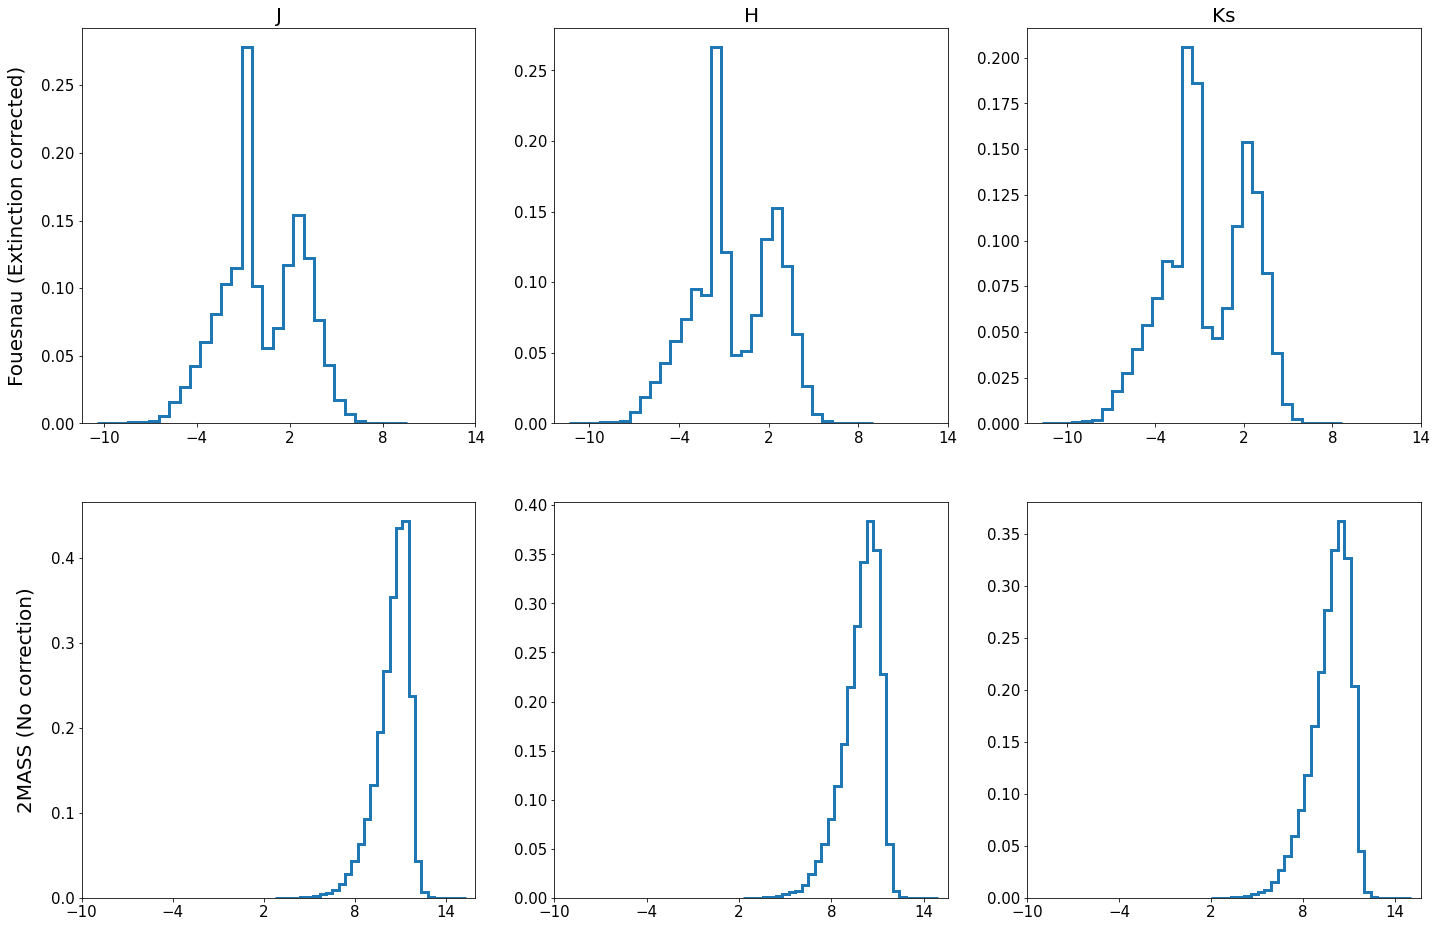

In [41]:
filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters_tmass = ['j_m', 'h_m', 'k_m']
filters = filters_fouesnau+filters_tmass
filter_titles = ['J', 'H', 'Ks']

row_titles = ['Fouesnau (Extinction corrected)', '2MASS (No correction)']

fig, axs = plt.subplots(nrows=2, ncols=3,figsize = (24,16))

for ax,col in zip(axs[0], filter_titles):
    ax.set_title(col, fontdict={'fontsize': 20})

for ax,row in zip(axs[:,0], row_titles):
    ax.set_ylabel(row, fontdict={'fontsize': 20}, labelpad=15)

for i, ax in enumerate(axs.flat):
    x_values = crossmatched_tmass_data[filters[i]].values
    ax.hist(x_values, bins=30, histtype='step', density=True, lw=3)
    #ax.set_xlabel('{}'.format(filters[i]), fontdict={'fontsize': 17}, labelpad=15)
    ax.set_xticks(np.linspace(-10, 14, 5))
    ax.tick_params(axis='both', which='major', labelsize=15)

fig_name = 'filter_distributions'
plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')


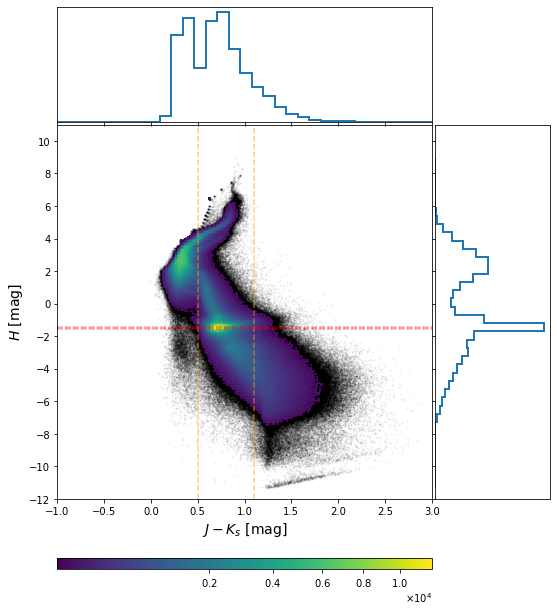

In [43]:
x_values = (crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50).values
y_values = crossmatched_tmass_data.H_p50.values

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x_values,y_values, ax, ax_histx, ax_histy, -1, 3, -12, 11)
#plt.title("Extinction \nCorrected \nPhotometry", fontdict={'fontsize' : 15})
#plt.show()

fig_name = 'color_index_vs_H_NOCUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

### Zoomed In Sample Density

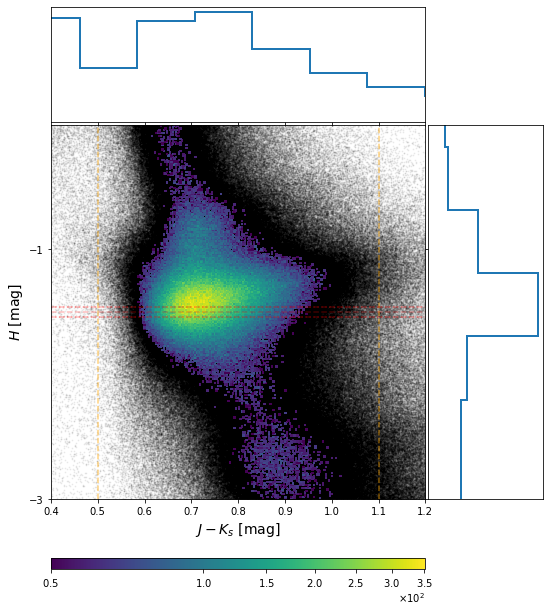

In [42]:
x_values = (crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50).values
y_values = crossmatched_tmass_data.H_p50.values

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x_values,y_values, ax, ax_histx, ax_histy, 0.4, 1.2, -3, 0)
#plt.title("Extinction \nCorrected \nPhotometry", fontdict={'fontsize' : 15})
#plt.show()

fig_name = 'color_index_vs_H_NOCUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

---

## Sample Cut Selection <a class="anchor" id="section5"></a>

In [10]:
print("Stars in the sample before making photometric cuts: {}".format(crossmatched_tmass_data.shape))

Stars in the sample before making photometric cuts: (4807089, 22)


In [11]:
# Create new column with quality flag being True or False

import re
def is_allowed_flg(string):

    charRe = re.compile(r'[^A-B]')
    string = charRe.search(string)
    return not bool(string)

crossmatched_tmass_data['is_qual_true'] = crossmatched_tmass_data.ph_qual.apply(is_allowed_flg)

### 2D Histogram After Imposing All Cuts

In [ ]:
# Example on how to impose different cuts on the dataset

cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample =  cut_sample[cut_sample.is_qual_true == True]
cut_sample = cut_sample[cut_sample.parallax_sigma/cut_sample.parallax < 0.2]
print(cut_sample.shape)

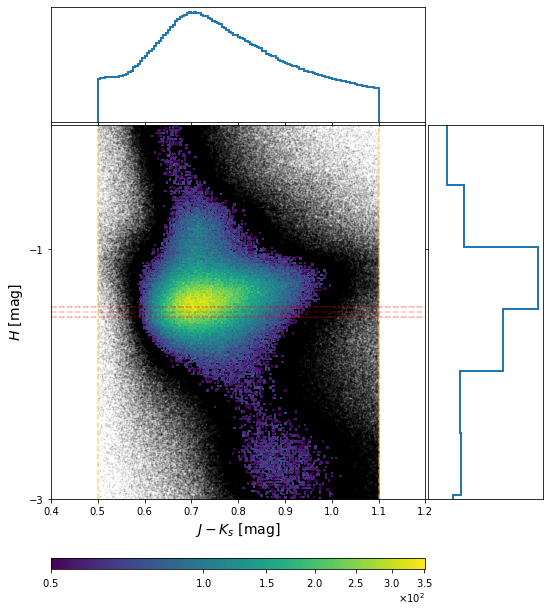

In [46]:
x_values = (cut_sample.J_p50 - cut_sample.Ks_p50).values
y_values = cut_sample.H_p50.values

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(x_values,y_values, ax, ax_histx, ax_histy, 0.4, 1.2, -3, 0)

fig_name = 'color_index_vs_H_NOCUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', dpi=300, facecolor='white')

### 1D Histograms of Error Distributions

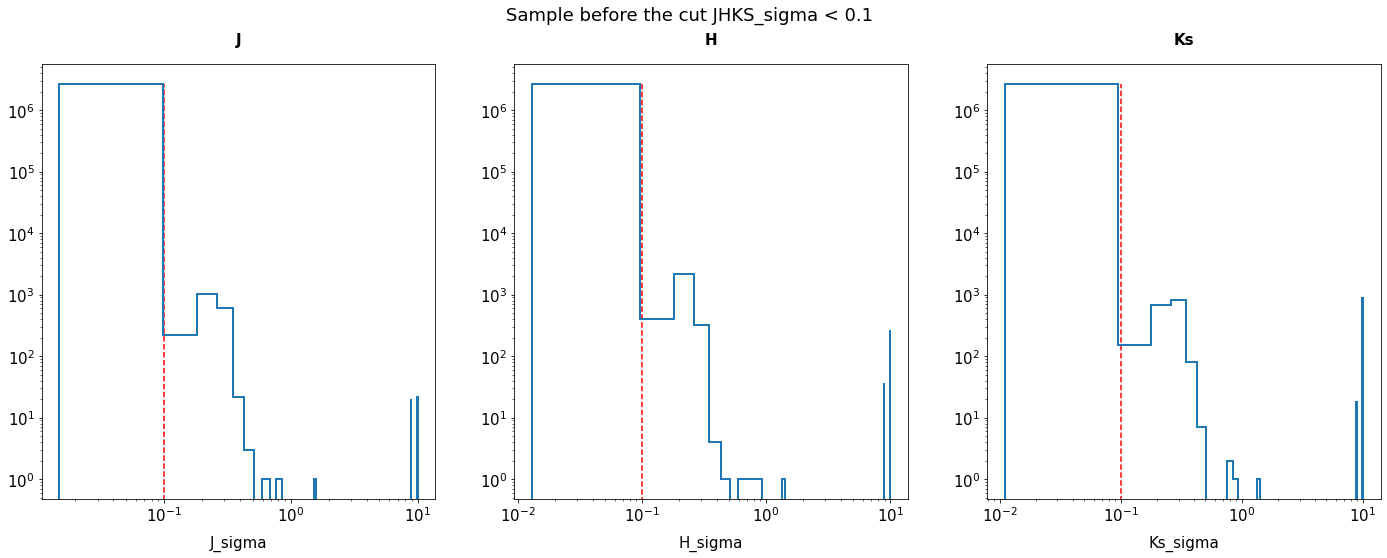

In [32]:
cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
#cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
#cut_sample =  cut_sample[crossmatched_tmass_data.is_qual_true == True]

from matplotlib import colors
plt.rc('text', usetex=False)

filters_fouesnau = ['J', 'H', 'Ks']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):
    y_values = cut_sample[filters_fouesnau[i]+'_sigma'].values 

    h = axs[i].hist(y_values, bins=120, histtype='step', density=False, lw=2)
    #cb = fig.colorbar(h[3], ax=axs[i], pad=0.02)

    axs[i].set_xlabel(filters_fouesnau[i]+'_sigma', fontdict={'fontsize': 15}, labelpad=10)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('{}'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')
    axs[i].vlines(0.1, 0, np.max(h[0]), colors='red', linestyles = '--')

fig.suptitle('Sample before the cut JHKS_sigma < 0.1', fontsize=18)

fig_name = 'JHKs_sigma_hist_NO_QUAL_CUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/error_plots/' + fig_name +'.png', dpi=300, bbox_inches='tight', facecolor='white')


### Plots after cut

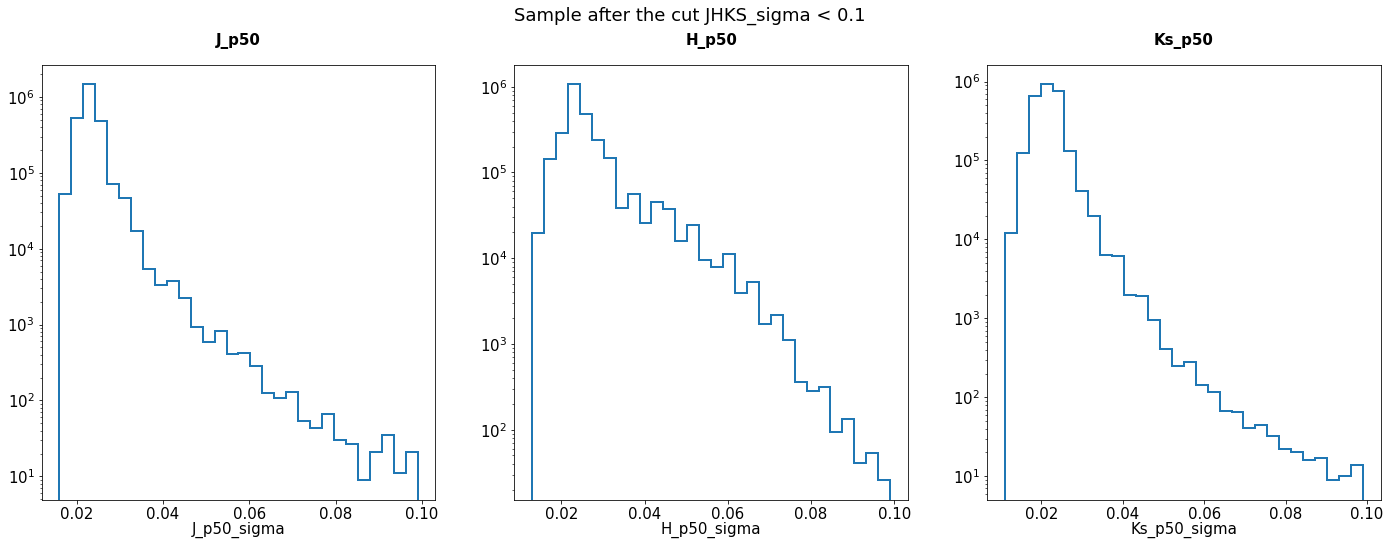

In [16]:
from matplotlib import colors
plt.rc('text', usetex=False)

cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample =  cut_sample[crossmatched_tmass_data.is_qual_true == True]

temp_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]

filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    x_values = cut_sample[filters_fouesnau[i]].values 
    y_values = cut_sample[filters[i]+'_sigma'].values 

    axs[i].hist(y_values, bins=30, histtype='step', density=False, lw=2)
    #cb = fig.colorbar(h[3], ax=axs[i], pad=0.02)

    axs[i].set_xlabel(filters_fouesnau[i]+'_sigma', fontdict={'fontsize': 15}, labelpad=0)

    axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('{}'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig.suptitle('Sample after the cut JHKS_sigma < 0.1', fontsize=18)

fig_name = 'JHKs_sigma_hist_QUAL_CUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/error_plots/' + fig_name +'.png', dpi=300, bbox_inches='tight', facecolor='white')


Error Distribution After Quality Flag Cut

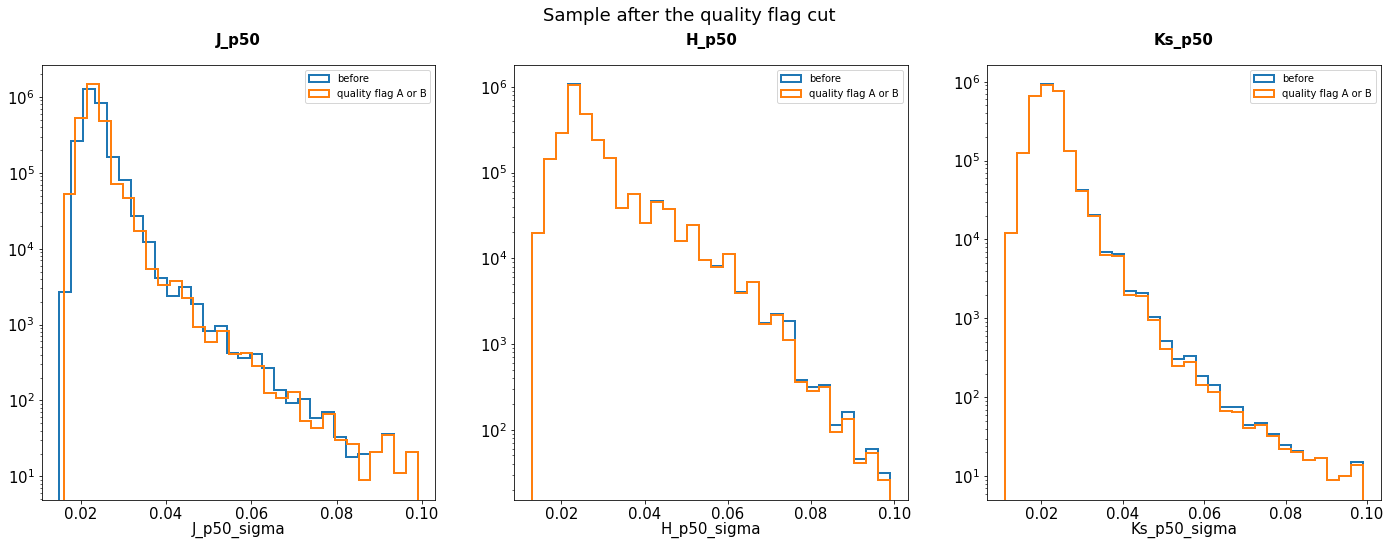

In [40]:
from matplotlib import colors
plt.rc('text', usetex=False)

cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample_qual =  cut_sample[crossmatched_tmass_data.is_qual_true == True]

filters_fouesnau = ['J_p50', 'H_p50', 'Ks_p50']
filters = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    x_values = cut_sample[filters_fouesnau[i]].values 
    y_values = cut_sample[filters[i]+'_sigma'].values 

    axs[i].hist(y_values, bins=30, histtype='step', density=False, lw=2, label='before')
    axs[i].hist(cut_sample_qual[filters[i]+'_sigma'].values , bins=30, histtype='step', density=False, lw=2, label='quality flag A or B')

    axs[i].set_xlabel(filters_fouesnau[i]+'_sigma', fontdict={'fontsize': 15}, labelpad=0)
    axs[i].legend(loc='upper right')
    axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('{}'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig.suptitle('Sample after the quality flag cut', fontsize=18)

fig_name = 'JHKs_sigma_hist_QUAL_CUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/error_plots/' + fig_name +'.png', dpi=300, bbox_inches='tight', facecolor='white')

Uncertainty Distributions After Removing Start with parallax_sigma/parallax > 0.2

(2670881, 23)


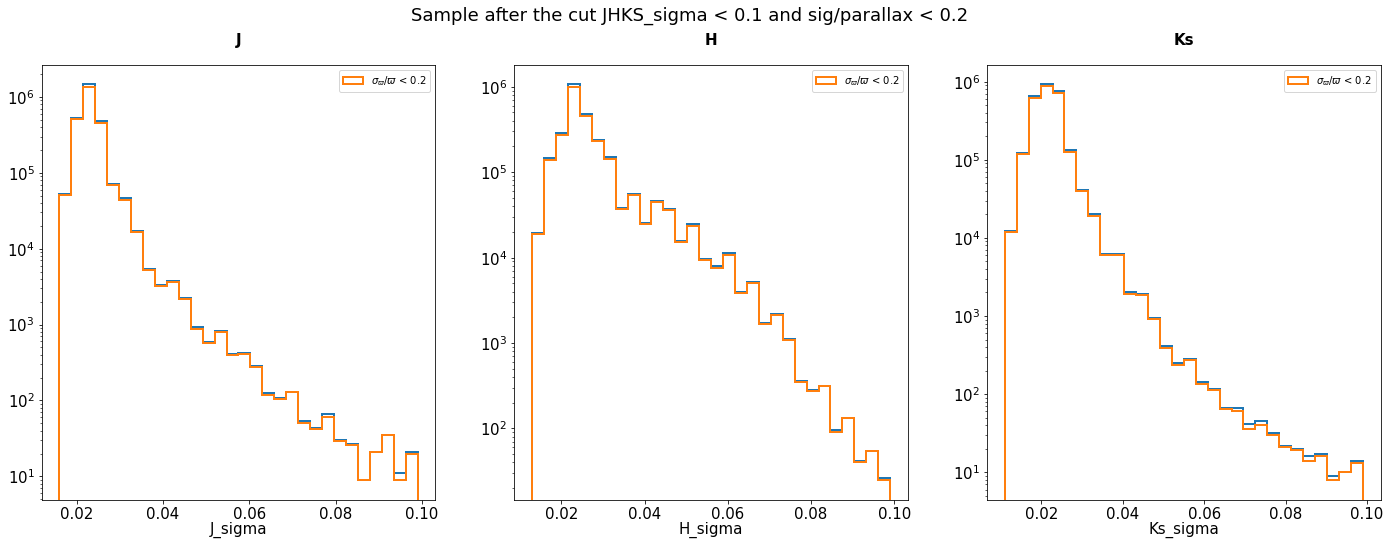

In [34]:
cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample =  cut_sample[cut_sample.is_qual_true == True]
cut_sample_parallax = cut_sample[cut_sample.parallax_sigma/cut_sample.parallax < 0.2]
print(cut_sample.shape)

filters_fouesnau = ['J', 'H', 'Ks']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (24,8))

for i, filter in enumerate(filters_fouesnau):

    y_values = cut_sample[filters_fouesnau[i]+'_sigma'].values
    y_values_parallax =  cut_sample_parallax[filters_fouesnau[i]+'_sigma'].values

    axs[i].hist(y_values, bins=30, histtype='step', density=False, lw=2)
    axs[i].hist(y_values_parallax, bins=30, histtype='step', density=False, lw=2, label=r"$\sigma_\varpi/\varpi$ < 0.2")

    axs[i].set_xlabel(filters_fouesnau[i]+'_sigma', fontdict={'fontsize': 15}, labelpad=0)
    axs[i].legend(loc='upper right')
    axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    axs[i].set_title('{}'.format(filters_fouesnau[i]), fontdict={'fontsize': 15}, pad=20, fontweight='bold')

fig.suptitle('Sample after the cut JHKS_sigma < 0.1 and sig/parallax < 0.2', fontsize=18)

fig_name = 'JHKs_sigma_hist_QUAL_PARALLAX_CUT'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/error_plots/' + fig_name +'.png', dpi=300, bbox_inches='tight', facecolor='white')

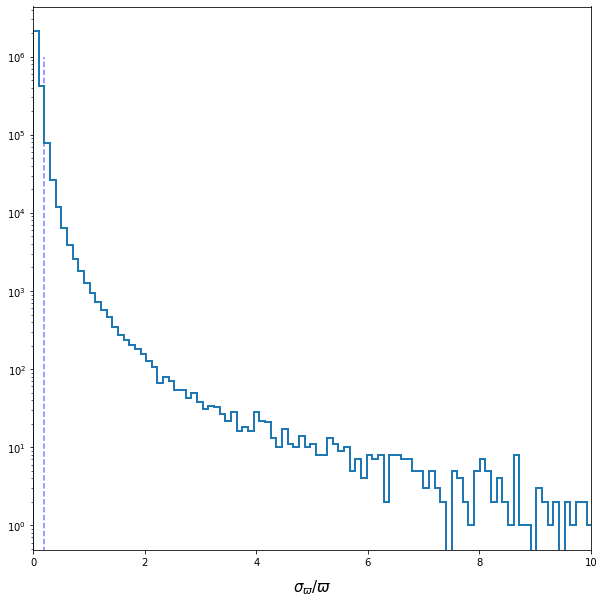

In [48]:
cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample =  cut_sample[crossmatched_tmass_data.is_qual_true == True]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

x_values = cut_sample['parallax_sigma'].values/cut_sample['parallax'].values 
ax.hist(x_values, bins=400, histtype='step', density=False, lw=2)
ax.set_xlabel(r'$\sigma_\varpi/\varpi$', fontdict={'fontsize': 15}, labelpad=10)
ax.set_xlim(0, 10)
ax.set_yscale('log')

ax.vlines([0.2], 0, 1e6, linestyles='dashed', alpha=0.5, colors='b')
#ax.set_ylabel('parallax_sigma', fontdict={'fontsize': 15}, labelpad=10)

## Checking Gaia photometry <a class="anchor" id="section6"></a>

In [ ]:
gaia_rv_data = vaex.from_csv('/scratch/sven/gaia_downloads/bayesian_distance_rv_stars.csv', convert=True)
print(gaia_rv_data.shape)
print(gaia_rv_data.get_column_names)

In [ ]:
gaia_photometry = vaex.from_csv('/scratch/sven/gaia_downloads/gaia_photometry_rv_data.csv', convert=True)
gaia_photometry.shape


In [ ]:
gaia_photometry_df = crossmatched_tmass_data.join(gaia_photometry, 
                                                    how='inner', 
                                                    left_on='source_id_tmass_xmass', 
                                                    right_on='source_id',
                                                    lsuffix='_tmass_xmass',
                                                    rsuffix='_gaia_phot')

In [ ]:
print(gaia_photometry_df.G_p50[0:1].values)
print(gaia_photometry_df.phot_g_mean_mag[0:1].values)
print(gaia_photometry_df.G[0:1].values)
print(gaia_photometry_df.A_G_p50[0:1].values)
print(gaia_photometry_df.A0_p50[0:1].values)



In [ ]:
#print(gaia_photometry_df.shape)
print(crossmatched_tmass_data.shape)

In [ ]:
gaia_photometry_df = gaia_photometry_df.join(gaia_rv_data, 
                                                    how='inner', 
                                                    left_on='source_id_tmass_xmass', 
                                                    right_on='source_id',
                                                    lsuffix='_gaia_phot',
                                                    rsuffix='_gaia_rv')

In [ ]:
from matplotlib import colors
plt.rc('text', usetex=False)

fig, ax = plt.subplots(figsize=(9, 18))

range = [[0,5], [-10, 15]]

Mg = gaia_photometry_df.phot_g_mean_mag.values - 5*np.log10(gaia_photometry_df.r_est.values) + 5

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(gaia_photometry_df.bp_rp.values, Mg, range=range, bins=500, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(gaia_photometry_df.bp_rp.values, Mg, alpha=0.05, s=1, color='k', zorder=0)

ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('$G_{BP} - G_{RP}$', fontdict={'size' : 14})
ax.set_ylabel('$M_G$', fontdict={'size' : 14})
cb.set_label("$\mathrm{Stellar~density}$")
plt.show()

In [ ]:
from matplotlib import colors
plt.rc('text', usetex=False)

fig, ax = plt.subplots(figsize=(9, 14))

range = [[0,5], [-20, 15]]

Mg = gaia_photometry_df.G_p50.values - 5*np.log10(gaia_photometry_df.r_est.values) + 5

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(gaia_photometry_df.BP_p50.values - gaia_photometry_df.RP_p50.values, Mg, range=range, bins=500, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(gaia_photometry_df.BP_p50.values - gaia_photometry_df.RP_p50.values, Mg, alpha=0.05, s=1, color='k', zorder=0)

ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('$G_{BP} - G_{RP}$', fontdict={'size' : 14})
ax.set_ylabel('$M_G$', fontdict={'size' : 14})
cb.set_label("$\mathrm{Stellar~density}$")
plt.show()

## Fitting Across ROI <a class="anchor" id="section7"></a>

In [10]:
cut_sample = crossmatched_tmass_data[((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) > 0.5) & ((crossmatched_tmass_data.J_p50 - crossmatched_tmass_data.Ks_p50) < 1.1)]
cut_sample = cut_sample[(cut_sample.J_sigma < 0.1) & (cut_sample.Ks_sigma < 0.1) & (cut_sample.H_sigma < 0.1)]
cut_sample =  cut_sample[cut_sample.is_qual_true == True]
cut_sample = cut_sample[cut_sample.parallax_sigma/cut_sample.parallax < 0.2]
#cut_sample.shape

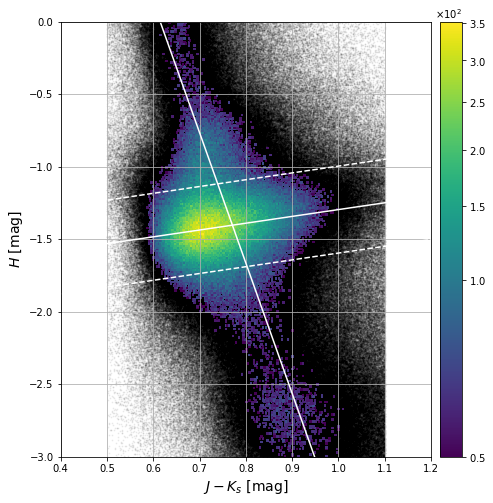

In [11]:
xlim_min = 0.4
xlim_max = 1.2
ylim_min = -3
ylim_max = 0


fig = plt.figure(figsize=(8, 8))

range = [[xlim_min, xlim_max], [ylim_min, ylim_max]]
x = (cut_sample.J_p50 - cut_sample.Ks_p50).values
y = cut_sample.H_p50.values
h = plt.hist2d(x, y, bins=250, range=range, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
plt.scatter(x, y, alpha=0.05, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical')

thresh_max = 150
thresh_min = 50
xc, yc = np.where((h[0] > thresh_min) & (h[0] < thresh_max))
fit_x = h[1][xc]
fit_y = h[2][yc]
cut_ids = np.where((fit_y < -2) | (fit_y > -1))
a, b = np.polyfit(fit_x[cut_ids], fit_y[cut_ids], 1)
plt.plot(h[1], a*h[1] + b, c='w')

thresh_max = 200
xc, yc = np.where(h[0] > thresh_max)
fit_x = h[1][xc]
fit_y = h[2][yc]
cut_ids = np.where((fit_y > -2) & (fit_y < -1))
a, b = np.polyfit(fit_x[cut_ids], fit_y[cut_ids], 1)
plt.plot(h[1], a*h[1] + b, c='w')

plt.plot(h[1], a*h[1] + b + 0.3, c='w', linestyle="--")
plt.plot(h[1], a*h[1] + b - 0.3, c='w', linestyle="--")

plt.xlabel(r'$J - K_s$ [mag]', fontdict={'fontsize' : 14})
plt.ylabel(r'$H$ [mag]',  fontdict={'fontsize' : 14})

plt.grid()
plt.show()


In [12]:
# Impose cut on sample

JKs = cut_sample.J_p50 - cut_sample.Ks_p50
test_sample = cut_sample[(cut_sample.H_p50 < a*JKs + b + 0.3) & (cut_sample.H_p50 > a*JKs + b - 0.3)]

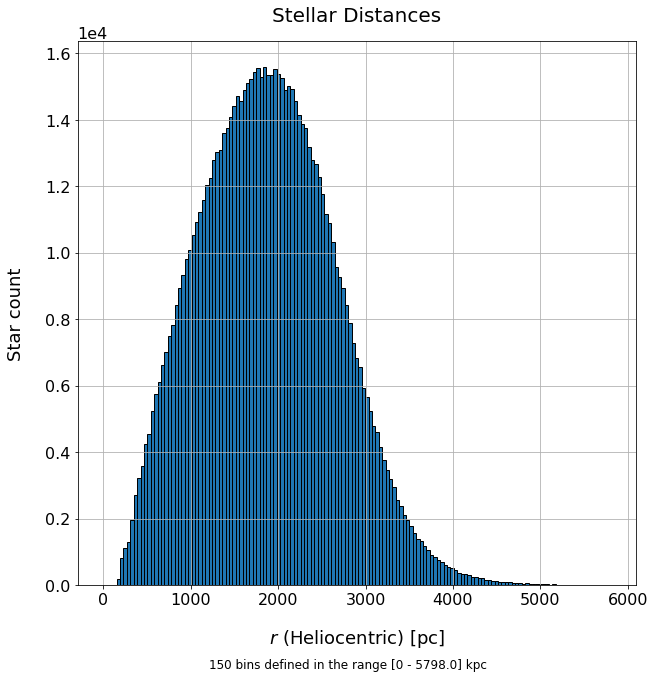

In [45]:
fig = plt.figure(figsize=(10, 10))

fig.patch.set_facecolor('white')

n_bins = 150
r_min = 0
r_max = np.max(test_sample.r_est.values)

plt.hist(test_sample.r_est, bins=np.linspace(r_min, r_max, n_bins))

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

txt="{0} bins defined in the range [{1} - {2}] kpc".format(n_bins, r_min, np.round(r_max))
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.xlabel(r'$r$ (Heliocentric) [pc]', fontdict={'fontsize': 18}, labelpad = 20);
plt.ylabel('Star count', fontdict={'fontsize': 18}, labelpad = 20);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

plt.rcParams["patch.force_edgecolor"] = True
plt.rc('font', **{'size':'16'})
plt.title("Stellar Distances", pad=20, fontdict={'fontsize': 20})

#plt.savefig("Star_Density_R_Presentation", dpi=300, facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [14]:
from import_functions import import_data

# Switch to Pandas
test_df = test_sample.to_pandas_df(['source_id', 'r_est'])

my_path = "/hdfs/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv"
icrs_data = import_data(path = my_path, is_bayes = True, debug = True)


Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110954  0.084926 -61.528791   0.057224   
7133469  4251811155377211776  280.393583  0.074122  -7.967930   0.074171   
7133470  4251939076692958336  281.

In [15]:
icrs_data = icrs_data.merge(test_df, on='source_id', suffixes=("", "_y"))

In [34]:
galcen_data = data_analysis.get_transformed_data(icrs_data, 
                                   include_cylindrical = True,
                                   debug = True, 
                                   is_source_included = True,
                                   is_bayes = True)

Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 2.319461552426219 sec


In [18]:
icrs_data.shape

(823650, 25)

In [16]:
def display_polar_histogram(galcen_data, n_bins=100, norm_max = 1000, r_limits = (), title = "Polar Plot"):

    from astropy.visualization.mpl_normalize import ImageNormalize
    from astropy.visualization import LogStretch

    fig= plt.figure(figsize=(10, 10), facecolor='white')
    
    # Init Data
    phi = galcen_data.phi
    r = galcen_data.r

    if not r_limits:
        min_r = np.min(galcen_data.r)
        max_r = np.max(galcen_data.r)     
    else:
        min_r = r_limits[0]
        max_r = r_limits[1]
        
    plt.ylim(min_r, max_r)
    
    # Init Bins
    rbins = np.linspace(0, max_r, n_bins)
    abins = np.linspace(-np.pi,np.pi, n_bins)

    norm_hist2d = ImageNormalize(vmin=0., vmax=norm_max, stretch=LogStretch())

    
    
    ax = fig.add_subplot(111, projection='polar')
    plt.hist2d(phi, r, bins=(abins, rbins), norm = norm_hist2d)
    ax.plot(np.pi, 8178, "*", markersize=10, color='red', alpha=0.75)
    plt.title(title, pad=20, fontdict={'fontsize': 20})

    # Set r label background color to black
    plt.setp(ax.get_yticklabels(), backgroundcolor="black")

    # Set r label font color to white
    ax.tick_params(axis="y", colors="white", labelrotation=45, grid_color="palegoldenrod")

    # Configure angle labels
    ax.set_thetamin(360)
    ax.set_thetamax(0)

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of stars in bin')

    plt.grid()
    #plt.show()
    
    return fig


In [17]:
fig2 = display_polar_histogram(galcen_data, n_bins=150, norm_max=5000, r_limits=(0, 15000), title = "Distribution on Galactic Pane")

NameError: name 'galcen_data' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')

n_bins = 150
z_min = np.min(galcen_data.z)
z_max = np.max(galcen_data.z)

plt.hist(galcen_data.z, bins=np.linspace(z_min, z_max, n_bins), label='Density', alpha=1)

#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

txt="{0} bins defined in the range [{1} - {2}] pc".format(n_bins, z_min, z_max)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.xlabel(r'$z$ [pc]', fontdict={'fontsize': 18}, labelpad = 20);
plt.ylabel('Star count', fontdict={'fontsize': 18}, labelpad = 20);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

plt.rcParams["patch.force_edgecolor"] = True
plt.rc('font', **{'size':'16'})
plt.title("Star Density Histogram (Non-Bayes)", pad=20, fontdict={'fontsize': 20})

#plt.savefig("Star_Density_R_Presentation", dpi=300, facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))

range = [[xlim_min, xlim_max], [ylim_min, ylim_max]]
x = (test_sample.J_p50 - test_sample.Ks_p50).values
y = test_sample.H_p50.values
h = plt.hist2d(x, y, bins=250, range=range, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
plt.scatter(x, y, alpha=0.05, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical')

Text(0.5, 1.0, 'Sample Distribution in Galactic Coordinates')

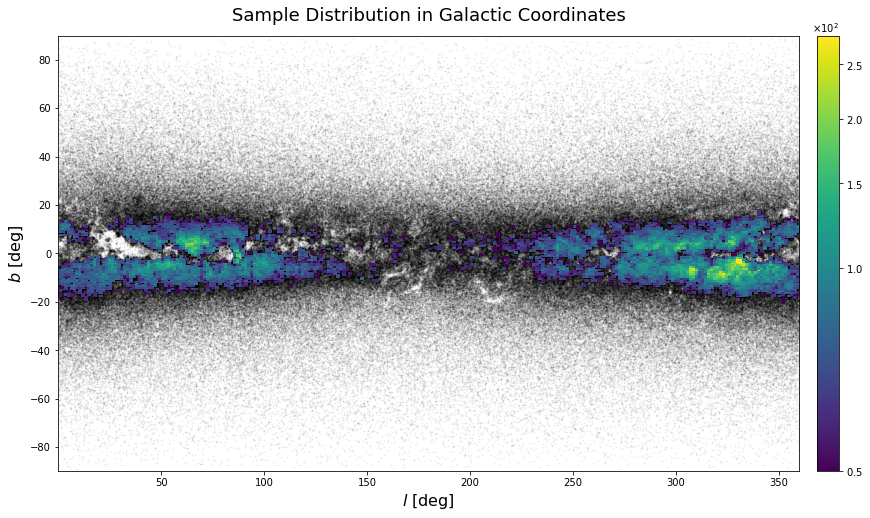

In [43]:
from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=list(icrs_data.ra)*u.degree, dec=list(icrs_data.dec)*u.degree, frame='icrs')

fig = plt.figure(figsize=(16, 8))

#range = [[xlim_min, xlim_max], [ylim_min, ylim_max]]
x = c.galactic.l.to_value()
y = c.galactic.b.to_value()
h = plt.hist2d(x, y, bins=250, cmin=50, norm=colors.PowerNorm(0.5), zorder=0.5)
plt.scatter(x, y, alpha=0.05, s=1, color='k', zorder=0)

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
plt.colorbar(h[3], pad=0.02, format=fmt, orientation='vertical')

plt.xlabel(r'$l$ [deg]', fontdict={'fontsize' : 16})
plt.ylabel(r'$b$ [deg]',  fontdict={'fontsize' : 16})

plt.title("Sample Distribution in Galactic Coordinates", fontsize=18, pad=15)
fig_name = 'sample_distribution_galactic_coords'
#plt.savefig('/home/sven/repos/gaia-tools/out/fouesnau_plots/' + fig_name +'.png', bbox_inches='tight', dpi=300, facecolor='white')

---